In [1]:
from datetime import datetime
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from pykrx import stock
from tqdm import tqdm
%matplotlib inline

In [193]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period_buy',40),('ma_period_sell',20))
    
    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None
        
        # 결과로 사용할 로그
        global timeBuy
        global timeClose
        global result
        global stock_code
        global listStockCode
        global costBuy
        global data_stock
        global timeDays
        # 결과로 사용할 임시
        timeBuyTemp = None
        timeCloseTemp = None
        costBuyTemp = None
        
        # 사용할 지표
        self.smaBuy = bt.ind.SMA(self.datas[0], period=self.params.ma_period_buy)
        self.smaSell = bt.ind.SMA(self.datas[0], period=self.params.ma_period_sell)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):  # 주문 내용 출력
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
#                 self.log(f'Buy Executed -- Price : {order.executed.price:.2f}, Cost : {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.timeBuyTemp = self.datas[0].datetime.date(0)
                self.costBuyTemp = f'{order.executed.value:.2f}'
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
#                 self.log(f'Sell Executed -- Price : {order.executed.price:.2f}, Cost : {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.timeCloseTemp = self.datas[0].datetime.date(0)
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
        self.order = None
        
    def notify_trade(self, trade):  # 주문 결과 출력
        if not trade.isclosed:
            return
#         self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        listStockCode.append(stock_code)
        timeBuy.append(self.timeBuyTemp)
        costBuy.append(self.costBuyTemp)
        timeClose.append(self.timeCloseTemp)
        timeDays.append(len(data_stock.loc[self.timeBuyTemp:self.timeCloseTemp,]))
        result.append(f'{trade.pnlcomm:.2f}')
        
    def next_open(self): #주문 생성
        if self.order:
            return
        if not self.position:
            if self.data_close[0] > self.smaBuy[0]:
#                 size = int(self.broker.getcash()*0.997 / self.datas[0].open)
                size = 1
#                 self.log(f'Buy created -- Price : {self.data_close[0]:.2f}')
                self.order = self.buy(size=size)
        else:
            if self.data_close[0] < self.smaSell[0]:
#                 self.log(f'Sell created -- Price : {self.data_close[0]:.2f}')
                self.order = self.sell(size=self.position.size)

In [2]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        
        # 결과로 사용할 로그
        global timeBuy
        global timeClose
        global result
        global stock_code
        global listStockCode
        global costBuy
        global data_stock
        global timeDays
        # 결과로 사용할 임시
        timeBuyTemp = None
        timeCloseTemp = None
        costBuyTemp = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.top)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.timeBuyTemp = self.datas[0].datetime.date(0)
                self.costBuyTemp = f'{order.executed.value:.2f}'
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
#                 self.log(f'Sell Executed -- Price : {order.executed.price:.2f}, Cost : {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.timeCloseTemp = self.datas[0].datetime.date(0)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        listStockCode.append(stock_code)
        timeBuy.append(self.timeBuyTemp)
        costBuy.append(self.costBuyTemp)
        timeClose.append(self.timeCloseTemp)
        timeDays.append(len(data_stock.loc[self.timeBuyTemp:self.timeCloseTemp,]))
        result.append(f'{trade.pnlcomm:.2f}')
        
    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = 1
                # buy order
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.sell(size=self.position.size)

In [215]:
# listStockCode = []
# timeBuy = []
# timeClose = []
# timeDays = []
# costBuy = []
# result = []

stock_code = '005960'
data_stock = fdr.DataReader(stock_code, start=datetime(2018,1,1),end=datetime(2018,12,31))
data = bt.feeds.PandasData(dataname=data_stock)

cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
# 
cerebro.adddata(data)
cerebro.broker.setcash(10000000)
cerebro.broker.setcommission(commission = 0.003)
cerebro.addstrategy(BBand_Strategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.run()

In [3]:
tickers_kospi = stock.get_market_ticker_list("20201231", market="KOSPI")
tickers_kosdaq = stock.get_market_ticker_list("20201231", market='KOSDAQ')
# tickers_kospi + tickers_kosdaq

In [4]:
listStockCode = []
timeBuy = []
timeClose = []
timeDays = []
costBuy = []
result = []
listErrorStockCode = []
for stock_code in tqdm(tickers_kospi + tickers_kosdaq):
    try:
        data_stock = fdr.DataReader(stock_code, start=datetime(2011,1,1),end=datetime(2020,12,31))
        data = bt.feeds.PandasData(dataname=data_stock)

        cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

        cerebro.adddata(data)
        cerebro.broker.setcash(10000000)
        cerebro.broker.setcommission(commission = 0.003)
        cerebro.addstrategy(BBand_Strategy)
#         cerebro.addobserver(bt.observers.BuySell)
#         cerebro.addobserver(bt.observers.Value)
        cerebro.run()
    except:
        listErrorStockCode.append(stock_code)
print(listErrorStockCode)

100%|██████████████████████████████████████████████████████████████████████████████| 2388/2388 [41:52<00:00,  1.05s/it]

['365550', '009900', '367340', '369370', '357550', '347860', '129890', '353060', '365590', '265740', '354200', '367460', '352940', '317690', '352770', '356860', '318020', '335810']


In [5]:
import pandas as pd
dfResult = pd.DataFrame({'stock_code':listStockCode,'buy':timeBuy,'close':timeClose,'days':timeDays,'cost':costBuy,'profit':result})
dfResult['profit'] = pd.to_numeric(dfResult['profit'])
dfResult['cost'] = pd.to_numeric(dfResult['cost'])
dfResult['result'] = (dfResult['profit'] / dfResult['cost'])
dfResult['resultDay'] = (dfResult['result']+1)**(1/dfResult['days'])-1
dfResult['score'] = [1 if value >0 else 0 for value in dfResult['result']]
dfResult['count'] = 1
dfResult = dfResult[dfResult.cost != 0 ] # 중간에 거래 정지된 경우 가격이 0으로 표시되기때문에 

In [ ]:
# 승률. 기간별 승률 (매수 기준), 평균 일별 수익률, 수익률 분포.

In [6]:
a = dfResult[['stock_code','result','resultDay','score','count']].groupby(by=['stock_code']).sum()
a['percent'] = a['score'] / a['count']
a.sort_values(by='percent')
a.sum()['score']
print(f'승률 : {a.sum()["score"]/a.sum()["count"]:.2%} ( {a.sum()["score"]} / {a.sum()["count"]})')
# a

승률 : 60.01% ( 30105.0 / 50167.0)


In [7]:
dfResult['score_0.5'] = [1 if value >0.004 else 0 for value in dfResult['result']]
dfResult['score_1'] = [1 if value >0.014 else 0 for value in dfResult['result']]

In [8]:
b = dfResult[['stock_code','count','score_0.5','score_1']].groupby(by=['stock_code']).sum()
print(f'승률 (loss 0.5% 기준) : {b.sum()["score_0.5"]/b.sum()["count"]:.2%} ( {b.sum()["score_0.5"]} / {b.sum()["count"]})')
print(f'승률 (lost 1% 기준) : {b.sum()["score_1"]/b.sum()["count"]:.2%} ( {b.sum()["score_1"]} / {b.sum()["count"]})')

승률 (loss 0.5% 기준) : 58.55% ( 29373 / 50167)
승률 (lost 1% 기준) : 54.74% ( 27463 / 50167)


In [9]:
print(f'평균 수익률 : {dfResult[["result"]].mean()[0]:.2%}')
print(f'수익 발생 시 평균 수익률 : {dfResult[dfResult.score == 1][["result"]].mean()[0]:.2%}')
print(f'수익 발생 시 최대 수익률 : {dfResult[dfResult.score == 1][["result"]].max()[0]:.2%}')
print(f'손실 발생 시 평균 수익률 : {dfResult[dfResult.score == 0][["result"]].mean()[0]:.2%}')
print(f'손실 발생 시 최대 수익률 : {dfResult[dfResult.score == 0][["result"]].min()[0]:.2%}')
print(f'평균 일별 수익률 : {dfResult[["resultDay"]].mean()[0]:.2%}')
print(f'평균 보유일 : {dfResult[["days"]].mean()[0]:.2f}')

평균 수익률 : 2.51%
수익 발생 시 평균 수익률 : 12.06%
수익 발생 시 최대 수익률 : 795.89%
손실 발생 시 평균 수익률 : -11.82%
손실 발생 시 최대 수익률 : -100.30%
평균 일별 수익률 : 0.25%
평균 보유일 : 44.63


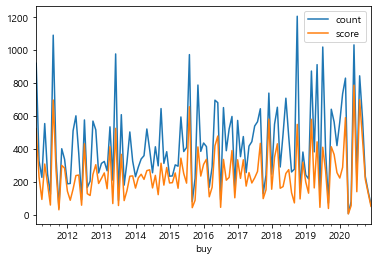

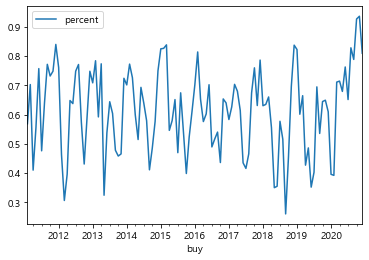

C:\Users\malko\anaconda3\envs\py38_64\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\malko\anaconda3\envs\py38_64\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


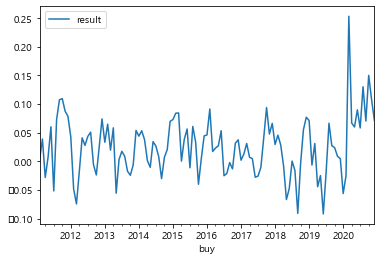

In [10]:
dfResult['buy'] = pd.to_datetime(dfResult['buy'])
dfResult.set_index(keys='buy',drop=False,inplace=True)
c = dfResult[['count','score']].groupby(pd.Grouper(freq='M')).apply(lambda x: np.sum(x))
c['percent'] = c['score']/c['count']
display(c[['count','score']].plot())
display(c[['percent']].plot())
d = dfResult[['result']].groupby(pd.Grouper(freq='M')).apply(lambda x: np.mean(x))
display(d.plot())